# Rekomendasi Peneliti Berdasarkan Rekam Jejak Publikasi  


# 1. Import Libraries
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
import ast
import re
warnings.filterwarnings('ignore')

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 2. Load & Preprocessing Dataset
---

In [2]:
# Load Dataset

# 1. Load dataset
df = pd.read_csv('dataset/arXiv_scientific dataset.csv')

# 2. Filter artikel pendek
df = df[df['summary_word_count'] >= 30]

# 3. Gabungkan title + summary + category
df['content'] = df['title'].astype(str) + " . " + df['summary'].astype(str) + " . " + df['category'].astype(str)

# 4. Ubah kolom authors ke list (dari string literal)
df['authors'] = df['authors'].apply(lambda x: ast.literal_eval(str(x)))

# 5. Explode ke per-penulis
df_exploded = df.explode('authors').copy()

# 6. Hapus author kosong/null/pendek
df_exploded = df_exploded[df_exploded['authors'].notnull()]
df_exploded = df_exploded[df_exploded['authors'].astype(str).str.strip().str.len() > 2]

# 7. Bersihin nama penulis
df_exploded['author_clean'] = (
    df_exploded['authors']
    .astype(str)
    .str.strip()
    .str.replace("'", "")
    .str.replace('"', '')
)

# 8. Tambahan filter regex: hapus simbol/nama aneh
df_exploded = df_exploded[
    df_exploded['author_clean'].apply(
        lambda x: bool(re.match(r"^[A-Za-z][A-Za-z ,.\-']{2,}$", x))
    )
]
# Check DataFrame information
print(df_exploded.info())
df_exploded.head()

<class 'pandas.core.frame.DataFrame'>
Index: 521974 entries, 0 to 136237
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  521974 non-null  object
 1   title               521974 non-null  object
 2   category            521974 non-null  object
 3   category_code       521974 non-null  object
 4   published_date      521974 non-null  object
 5   updated_date        521974 non-null  object
 6   authors             521974 non-null  object
 7   first_author        521974 non-null  object
 8   summary             521974 non-null  object
 9   summary_word_count  521974 non-null  int64 
 10  content             521974 non-null  object
 11  author_clean        521974 non-null  object
dtypes: int64(1), object(11)
memory usage: 51.8+ MB
None


,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count,content,author_clean
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,8/1/93,8/1/93,M. L. Ginsberg,'M. L. Ginsberg',Because of their occasional need to return to ...,79,Dynamic Backtracking . Because of their occasi...,M. L. Ginsberg
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,8/1/93,8/1/93,M. P. Wellman,'M. P. Wellman',Market price systems constitute a well-underst...,119,A Market-Oriented Programming Environment and ...,M. P. Wellman
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,9/1/93,9/1/93,I. P. Gent,'I. P. Gent',We describe an extensive study of search in GS...,167,An Empirical Analysis of Search in GSAT . We d...,I. P. Gent
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,9/1/93,9/1/93,T. Walsh,'I. P. Gent',We describe an extensive study of search in GS...,167,An Empirical Analysis of Search in GSAT . We d...,T. Walsh
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,F. Bergadano,'F. Bergadano',As real logic programmers normally use cut (!)...,174,The Difficulties of Learning Logic Programs wi...,F. Bergadano


# 3. Exploratory Data Analysis (EDA)
---

In [3]:
print(f"Total Article: {len(df)}")
print(f"Average Content Length: {df['content'].str.len().mean():.2f} words")
print(f"Jumlah Missing Values:\n{df.isnull().sum()}")

Total Article: 135979
Average Content Length: 1240.40 words
Jumlah Missing Values:
id                    0
title                 0
category              0
category_code         0
published_date        0
updated_date          0
authors               0
first_author          0
summary               0
summary_word_count    0
content               0
dtype: int64


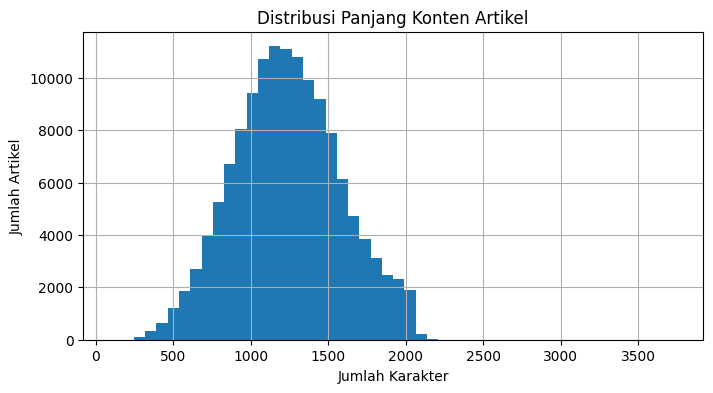

In [4]:
df['content_length'] = df['content'].str.len()

plt.figure(figsize=(8, 4))
df['content_length'].hist(bins=50)
plt.title("Distribusi Panjang Konten Artikel")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Jumlah Artikel")
plt.show()

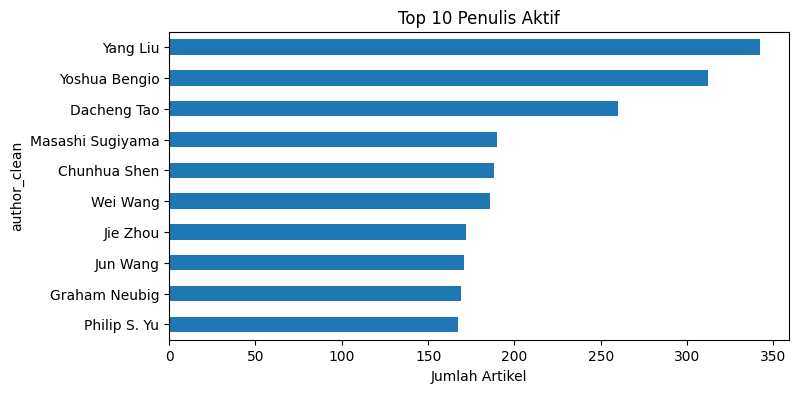

In [5]:
df_exploded['author_clean'].value_counts().head(10).plot(kind='barh', figsize=(8,4), title='Top 10 Penulis Aktif')
plt.xlabel("Jumlah Artikel")
plt.gca().invert_yaxis()
plt.show()

# 4. Author Profiling (Gabung Publikasi per Peneliti)
---

In [6]:
author_texts = df_exploded.groupby('author_clean')['content'].apply(lambda texts: " ".join(texts)).reset_index()
print(f"Total Unique Researcher: {len(author_texts)}")
author_texts.head()

Total Unique Researcher: 188075


,author_clean,content
0,A . M. Barrett,A multi-path 2.5 dimensional convolutional neu...
1,A Arunkumar,Investigation of Ensemble features of Self-Sup...
2,A Atyabi,Differential Evolution for Efficient AUV Path ...
3,A Badano,The stochastic digital human is now enrolling ...
4,A Baskar,Composition of Relational Features with an App...


# 5. Sentence Embedding
---

In [7]:
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

# 6. Batch Processing Embedding
---

In [8]:
embeddings = []
batch_size = 1000

for i in tqdm(range(0, len(author_texts), batch_size)):
    batch_texts = author_texts['content'].iloc[i:i+batch_size].tolist()
    batch_embeddings = model.encode(batch_texts, show_progress_bar=False)
    embeddings.extend(batch_embeddings)

# Simpan hasil embedding
author_texts['embedding'] = embeddings

100%|██████████| 189/189 [07:48<00:00,  2.48s/it]


# 7. Sistem Rekomendasi Peneliti
---

In [9]:
def recommend_researcher(query, top_n=5):
    query_emb = model.encode(query).reshape(1, -1)
    embeddings_array = np.vstack(author_texts['embedding'])

    sims = cosine_similarity(query_emb, embeddings_array)[0]
    top_indices = np.argsort(sims)[::-1][:top_n]

    recommendations = author_texts.iloc[top_indices][['author_clean']].copy()
    recommendations['similarity'] = sims[top_indices]

    return recommendations

In [10]:
query = "deep learning for healthcare"
recommended = recommend_researcher(query)
recommended

,author_clean,similarity
3219,Ahmad Zaib,0.748852
70295,Jeroen A. W. M. van der Laak,0.716909
83213,Kathryn Rough,0.711718
150261,Stylianos Serghiou,0.711718
119886,Patrick Tighe,0.709087


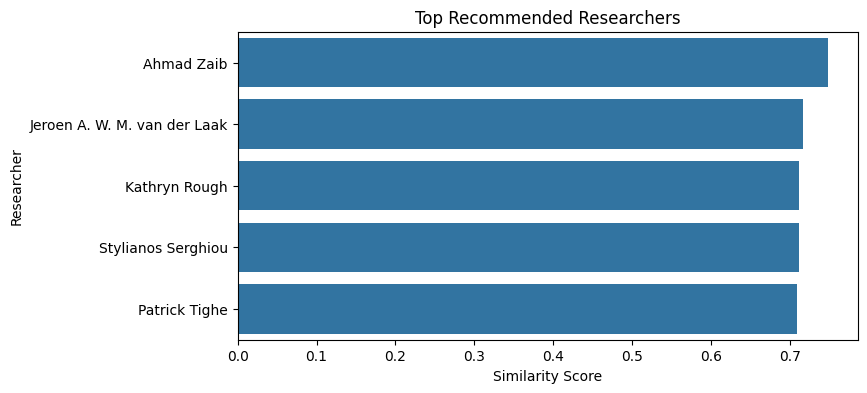

In [11]:
# Visualize the top recommended researchers
plt.figure(figsize=(8, 4))
sns.barplot(x=recommended['similarity'], y=recommended['author_clean'], orient='h')
plt.xlabel('Similarity Score')
plt.ylabel('Researcher')
plt.title('Top Recommended Researchers')
plt.show()

# 8. Verifikasi Peneliti
---

In [12]:
query_emb = model.encode(query)
similarity_threshold = 0.5
results = []

for author in recommended['author_clean']:
    df_author = df_exploded[df_exploded['author_clean'] == author][['title', 'summary', 'category']].copy()
    
    if df_author.empty:
        total_pub = 0
        relevant_pub = 0
        relevance_ratio = 0
        relevant_titles = []
    else:
        df_author['summary_emb'] = df_author['summary'].astype(str).apply(lambda x: model.encode(x))
        df_author['similarity'] = df_author['summary_emb'].apply(lambda x: cosine_similarity([query_emb], [x])[0][0])
        df_author['relevant'] = df_author['similarity'] >= similarity_threshold

        total_pub = len(df_author)
        relevant_pub = df_author['relevant'].sum()
        relevance_ratio = relevant_pub / total_pub if total_pub > 0 else 0
        relevant_titles = df_author[df_author['relevant']]['title'].tolist()

    results.append({
        'author': author,
        'total_pub': total_pub,
        'relevant_pub': relevant_pub,
        'relevance_ratio': relevance_ratio,
        'matched_titles': relevant_titles
    })

results_df = pd.DataFrame(results)
results_df


,author,total_pub,relevant_pub,relevance_ratio,matched_titles
0,Ahmad Zaib,1,1,1.0,[Deep Learning for Medical Image Processing: O...
1,Jeroen A. W. M. van der Laak,1,1,1.0,[A Survey on Deep Learning in Medical Image An...
2,Kathryn Rough,1,1,1.0,[Deep Learning for Epidemiologists: An Introdu...
3,Stylianos Serghiou,1,1,1.0,[Deep Learning for Epidemiologists: An Introdu...
4,Patrick Tighe,1,1,1.0,[Deep EHR: A Survey of Recent Advances in Deep...
